# Bagging and AdaBoost

In this notebook, I will implement algorithms described in Sections 14.2 and 14.3 of the book PRML, i.e., bagging and adaboost for binary classifications.

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import datasets

%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1. Setting

* $N \in \mathbb{N}$ : the number of observation data
* $X = (x_0, x_1, \dots, x_{N-1})$ : the set of observation data. All $x_n$ belong to an appropriatespecified set, say, $\mathcal{X}$.
* $T = (t_0, t_1, \dots, t_{N-1})$ : the target labels.
* $y : \mathcal{X} \times \Theta \rightarrow \{1, -1\}$ : a binary classifier parametrized by $\theta \in \Theta$.

## 2. Theory 

In this notebook, we construct strong classifier from a given simple classifier, which we call a base classifier. 

### 2.1 Base classifier : decision stump

#### 2.1.1 Definition 
Here, for simplicity, we assume $\mathcal{X} = \mathbb{R}^D$ with $D \in \mathbb{N}$, and use decision stump as base classifiers. 

A decision stump is characterized by parameter $\theta = (d, a, s) \in \{ 0,1, \dots, D-1 \} \times \mathbb{R} \times \{ 1, -1 \} $, where its prediction is given by
$$
\begin{align}
    y(x, (d,a,s)) = 
    \begin{cases}
        s & (x_d \geq a ) \\
        -s & (x_d < a)
    \end{cases}
\end{align}
$$
In essence, the decision stump $y(\cdot, (d,a,s))$ makes prediction according to whether the $d$ th coordinate of the input is larger than $a$ or not. 

#### 2.1.2 Training
In training a decision stump, we choose a parameter $\theta$ that minimizes
$$
\begin{align}
    \sum_{n=0}^{N-1} w_n I\left[ y(x_n, \theta) \neq t_n \right]. 
\end{align}
$$

Given training data $x_0, \dots, x_{N-1}$, there are essentially only $2D(N-1)$ possible decision stumps because there are
* two ways of choosing the sign $s$, 
* $D$ possible ways of choosing the dimension $d$, and
* $N-1$ possible ways of choosing the position of the threshold $a$. 

As to the las point: although there are infinitely many ways of choosing $a$, here we limit the possible values of $a$ to be the average of two adjacent (in terms of $d$ the coordinate) inpout points, because this limitation does not affect the values of the error function. 

In the later implementation, we perform this exhaustive search.

### 2.2 Bagging 

The idea of bagging, or bootstrap aggregation, is to train $M$ base classifiers using different "training data" for each classifier, where we obtain the "training data" by resampling from the original training data. 

#### 2.2.1 Training 

For $m = 0,1, \dots, M-1$, 
1. randomly sample $N$ data points from $(X,T)$ with replacement, and
2. train the $m$ th classifier $y(\cdot, \theta_m)$ using the resampled data. 

#### 2.2.2 Prediction 
Output the prediction for input $x$ by 
$$
\begin{align}
    y_{bag}(x) = \frac{1}{M} \sum_{m=0}^{M-1} y(x, \theta_m)
\end{align}
$$

### 2.3 AdaBoost

#### 2.3.1 Training

In AdaBoost, we train the classifier following the algorithm shown below: 

0. input : training data (X, T), base classifier $y$, the number of boosting $M$. 
1. Initialize data weighs $(w_0, w_1, \dots, w_{N-1})$ as $w^{(0)}_{n} = 1/N$. 
2. For $m = 1, \dots, M$: 
    1. Choose $\theta_m \in \Theta$ such that
    $$
    \begin{align}
        \sum_{n=1}^{N} w^{(m)}_{n} I \left[ y(x_n, \theta_m) \neq t_n \right]
    \end{align}
    $$
    is minimized.
    2. Evalute 
    $$
    \begin{align}
        \varepsilon_m &:= \sum_{n=1}^{N} w^{(m)}_{n}  I \left[ y(x_n, \theta_m) \neq t_n \right] \\     
        \alpha_m &:= \log \left(\frac{1 - \varepsilon_m}{\varepsilon_m} \right)
    \end{align}
    $$
    3. Update the data weight by 
    $$
    \begin{align}
        \tilde{w}^{(m+1)}_{n} &= w^{(m)}_{n} \exp\left\{ \alpha_m I \left[ y(x_n, \theta_m) \neq t_n \right]  \right\} \\
        w^{(m+1)}_{n} &= \frac{\tilde{w}^{(m+1)}_{n}}{ \sum_{n'=1}^{N} \tilde{w}^{(m+1)}_{n'} }
    \end{align}
    $$
    
Note :
* We normalize the weight here.
* It is implicitly assumed that the base classifier is better than random in the sense that $\varepsilon_m < \frac{1}{2}$ for all $m$. As far as I understand, the algorithm does not work when $\varepsilon_m > \frac{1}{2}$.

#### 2.3.2 Prediction 

Having obtained the classifier, the predicted label for input $x$ is given by 
$$
\begin{align}
    \textrm{sign} \left[ \sum_{m=0}^{M-1} \alpha_m y(x, \theta_m) \right]
\end{align}
$$

## 3. From math to code

### 3.1  Decision stump

In fitting a decision stump, we 
* first perform the exhaustive search over $s$ and $a$ for each dimension using fit_onedim (where the dimension $d$ is given), and 
* then compare the result for each dimension $d$. 

In fit_onedim, we use the folowoing arrays, assuming that $x$ and $w$ are sorted according the value of the $d$ th coordinate of $x$:  
* pred : (N-1, N) array, where pred[m,n] = $y\left(x_n, \left(d, \frac{x_m + x_{m+1}}{2} \right), 1 \right)$. Note that it can generated easily by using np.tri (Although it is inefficient in terms of memory. ).
* result : (N-1, N) array, where result[m,n] = $I \left[ y\left(x_n, \left(d, \frac{x_m + x_{m+1}}{2} \right), 1 \right) \neq t_n\right] $
* errs : (2, N-1) array, where 
    * errs[0,m] = $\sum_{n=0}^{N-1} w_n I \left[ y\left(x_n, \left(d, \frac{x_m + x_{m+1}}{2} \right), 1 \right) \neq t_n\right] $
    * errs[1,m] = $\sum_{n=0}^{N-1} w_n I \left[ y\left(x_n, \left(d, \frac{x_m + x_{m+1}}{2} \right), -1 \right) \neq t_n\right] $




In [2]:
class Decision_stump:
    
    
    def fit_onedim(self, X, T, sample_weight, d):
        N = len(X)
        # Here we sort everything according the d th coordinate of X
        sort_ind = np.argsort(X[:,d])
        sorted_label = T[sort_ind]
        sorted_input = X[sort_ind]
        sorted_sample_weight = sample_weight[sort_ind]
        
        pred = -2*np.tri(N-1, N, 0) + 1 
        result = 1*(pred != np.reshape(sorted_label, (1,N)) )
        
        # The (weighted) error is calculated for each classifier
        errs = np.zeros((2,N-1))
        errs[0] = result @ sorted_sample_weight
        errs[1] = (-result+ 1) @ sorted_sample_weight
        
        # Here, we select the best threshold and sign
        ind = np.unravel_index(np.argmin(errs, axis=None), errs.shape)
        sign = -2*ind[0] + 1
        thresh = 0.5* ( sorted_input[ind[1],d] + sorted_input[ind[1]+1, d] ) 
        err = errs[ind]
        return sign, thresh, err

        
    def fit(self, X, T, sample_weight=None):
        N = len(X)
        D = len(X[0])
        
        if sample_weight is None:
            sample_weight = np.ones(N)/N
        
        signs = np.zeros(D)
        threshs = np.zeros(D)
        errs = np.zeros(D)
        for d in range(D):
            signs[d], threshs[d], errs[d] = self.fit_onedim(X, T, sample_weight, d)
        self.d = np.argmin(errs)
        self.sign = signs[self.d]
        self.thresh = threshs[self.d]           

    def predict(self, X):
        return self.sign*( 2*(X[:,self.d] >= self.thresh) - 1 )

### 3.2 Bagging 

The implementation is rather straightforward. 

The code is written in a that it can be used for other base classifiers, asuming that the base classifier class has a fit method, which takes input data, label, and sample weight.

In [3]:
class Bagging:
    def __init__(self, BC, M):
        self.BC = BC # base classifier class
        self.M = M
        self.clfs = np.empty(self.M, dtype='object')

    def fit(self, X, T):
        N = len(X)
        for m in range(self.M):
            self.clfs[m] = self.BC()
            
            # resampling is performed here
            sample_ind = np.random.randint(0,N,N)
            X_resampled = X[sample_ind] 
            T_resampled = T[sample_ind]
            # traing the classifier using the resampled training data
            self.clfs[m].fit(X_resampled, T_resampled)
            
    def predict(self, Xtest):
        base_pred = np.zeros((self.M, len(Xtest)))
        for m in range(self.M):
            base_pred[m] = self.clfs[m].predict(Xtest)
        return np.sign(  np.sum(base_pred, axis = 0 ) )

### 3.3 AdaBoost

The code is also written in a that it can be used for other base classifiers, asuming that the base classifier class has a fit method, which takes input data, label, and sample weight. 

* X : (N,D) array
* T : (N,) array
* alpha : (M,) array, alpha[m] = $\alpha_m$

In [4]:
class Adaboost:
    def __init__(self, BC, M):
        self.BC = BC # base classifier class
        self.M = M
        self.alpha = np.zeros(self.M)
        self.clfs = np.empty(self.M, dtype='object')
        
    def fit(self, X, T):
        N = len(X)
        w = 1.0/N * np.ones(N) # initialize the weight
        for m in range(self.M):
            # invoke the base classifier
            self.clfs[m] = self.BC()
            self.clfs[m].fit(X, T, sample_weight = w)
            pred_err = (self.clfs[m].predict(X) != T) # prediction error
            
            # calculate the epsilon and alpha
            ep = np.sum ( w*pred_err)
            
            self.alpha[m] = np.log(1.0/ep - 1)
            
            # update the weight
            w = w * np.exp(  self.alpha[m]* pred_err )
            w = w/np.sum(w)
        
    def predict(self, Xtest):
        base_pred = np.zeros((self.M, len(Xtest)))
        for m in range(self.M):
            base_pred[m] = self.clfs[m].predict(Xtest)
        return np.sign( np.sum(np.reshape(self.alpha,(self.M,1))*base_pred, axis=0)  )

## 4. Experiment

In [5]:
N = 50
xdat,tdat = datasets.make_moons(n_samples = N, noise = 0.1)
tdat = 2*tdat-1

xx = np.linspace(np.min(xdat[:,0]),np.max(xdat[:,0]),101)
yy = np.linspace(np.min(xdat[:,1]),np.max(xdat[:,1]),100)
Xtest = np.array([[x,y] for x in xx  for y in yy])
xxx,yyy = np.meshgrid(xx,yy)

def plot_result(clf):
    plt.plot(xdat[:,0][tdat==1],xdat[:,1][tdat==1],"o",label="1")
    plt.plot(xdat[:,0][tdat==-1],xdat[:,1][tdat==-1],"o",label="-1")
    plt.legend()
    pred_val = clf.predict(Xtest)
    pred_val_2D = np.reshape(pred_val,(len(xx),len(yy))).T
    plt.pcolormesh(xxx,yyy,pred_val_2D)
    plt.colorbar()
    plt.show()

### 4.1 Single decision stump

First, let us quickly see the performance of the decision stump. 

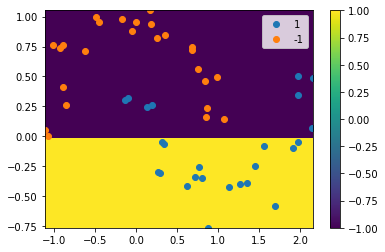

In [6]:
ds = Decision_stump()
ds.fit(xdat,tdat, np.ones(N)/N)
plot_result(ds)

### 4.2 Bagging

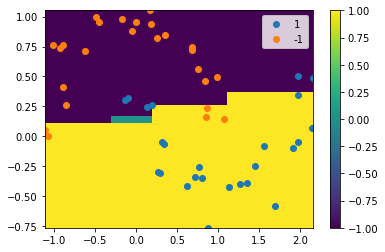

In [7]:
bag = Bagging(Decision_stump, 100)
bag.fit(xdat,tdat)
plot_result(bag)

We can see that the result slightly improved compared with the case with single decision stump.

### 4.3 AdaBoost

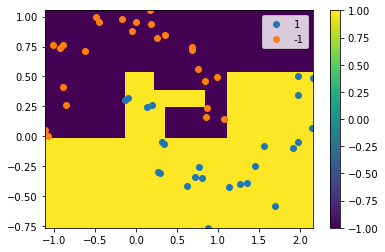

In [8]:
ada = Adaboost(Decision_stump, 100)
ada.fit(xdat,tdat)
plot_result(ada)

Now, we can see that the decision boundary fits well with the data. 